# RGB与LAB转换

In [42]:
#coding:utf-8
%matplotlib inline
import numpy as np
import cv2
import scipy
from scipy import linalg
import matplotlib.pyplot as plt

In [43]:
src = cv2.cvtColor(cv2.imread('../datas/f2.jpg'),cv2.COLOR_BGR2RGB)

In [72]:


def rgb2lab(src):
    rgb = np.float64(src) / 255.0
    dst = np.zeros_like(rgb)
    
    def invgammacorrection(Rp):
        R = np.zeros_like(Rp)
        idx = (R <= 0.0404482362771076)
        R[idx] = Rp[idx] / 12.92
        R[~idx] = np.power(((Rp[~idx] + 0.055) / 1.055),2.4)
        return R

    def f(Y):
        fY = np.power(Y,1/3)
        idx = (Y < 0.008856)
        fY[idx] = Y[idx] * (841 / 108) + (4 / 29)
        return fY

    def invf(fY):
        Y = np.power(fY,3.0)
        idx = (Y < 0.008856)
        Y[idx] = (fY[idx] - 4 / 29) * (108 / 841)
        return Y
    
    R = invgammacorrection(rgb[:,:,0])
    G = invgammacorrection(rgb[:,:,1])
    B = invgammacorrection(rgb[:,:,2])
    
    # RGB转换成 XYZ
    T = linalg.inv(np.array([[3.2406, -1.5372, -0.4986],
                             [ -0.9689, 1.8758, 0.0415],
                             [ 0.0557, -0.2040, 1.057]]))
    dst[:,:,0] = T[0][0] * R + T[0][1] * G + T[0][2] * B
    dst[:,:,1] = T[1][0] * R + T[1][1] * G + T[1][2] * B
    dst[:,:,2] = T[2][0] * R + T[2][1] * G + T[2][2] * B
    
    # XYZ转换成LAB
    WhitePoint = [0.950456,1,1.088754]
    X = (dst[:,:,0] / WhitePoint[0]).copy()
    Y = (dst[:,:,1] / WhitePoint[1]).copy()
    Z = (dst[:,:,2] / WhitePoint[2]).copy()
    
    fX = f(X)
    fY = f(Y)
    fZ = f(Z)
    
    dst[:,:,0] = 116 * fY - 16
    dst[:,:,1] = 500 * (fX - fY)
    dst[:,:,2] = 200 * (fY - fZ)
    
    return dst
    

In [73]:
lab = rgb2lab(src)

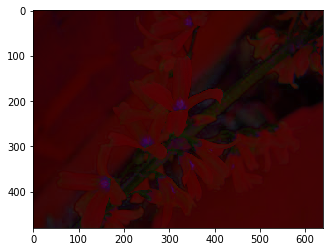

In [77]:
plt.imshow(cv2.convertScaleAbs(lab*2.5))

In [78]:
def lab2rgb(lab):
    dst = np.zeros_like(lab)
    
    def invf(fY):
        Y = np.power(fY,3.0)
        idx = (Y < 0.008856)
        Y[idx] = (fY[idx] - 4 / 29) * (108 / 841)
        return Y
    
    def gammacorrection(R):
        Rp = np.zeros_like(R)
        idx = (R <= 0.0031306684425005883)
        Rp[idx] = 12.92 * R[idx]
        Rp[~idx] = np.power(1.055 * R[~idx],0.416666666666666667) - 0.055
        return Rp
    
    WhitePoint = [0.950456,1,1.088754]
    fY = ((lab[:,:,0] + 16) / 116).copy()
    fX = (fY + lab[:,:,1] / 500).copy()
    fZ = (fY - lab[:,:,2] / 200).copy()
        
    X = (WhitePoint[0] * invf(fX)).copy()
    Y = (WhitePoint[1] * invf(fY)).copy()
    Z = (WhitePoint[2] * invf(fZ)).copy()
        
    T = [[3.2406, -1.5372, -0.4986],
             [-0.9689, 1.8758, 0.0415],
             [0.0557, -0.2040, 1.057]]
    
    R = (T[0][0] * X + T[0][1] * Y + T[0][2] * Z).copy()
    G = (T[1][0] * X + T[1][1] * Y + T[1][2] * Z).copy()
    B = (T[2][0] * X + T[2][1] * Y + T[2][2] * Z).copy()
        
    addwhite = -cv2.min(cv2.min(cv2.min(R,G),B),0)
    R = R + addwhite
    G = G + addwhite
    B = B + addwhite
        
    dst[:,:,0] = gammacorrection(R)
    dst[:,:,1] = gammacorrection(G)
    dst[:,:,2] = gammacorrection(B)
        
    return dst * 255
        

In [79]:
rgb = lab2rgb(lab)
print(rgb[:,:,1])
print(rgb.dtype)

[[51.10210184 51.78695929 52.46198177 ... 52.23804347 51.78695929
  50.40701048]
 [51.33150452 51.78695929 52.46198177 ... 52.01304059 51.78695929
  51.10210184]
 [51.33150452 51.78695929 52.23804347 ... 52.01304059 52.01304059
  51.78695929]
 ...
 [48.25592106 48.25592106 48.25592106 ... 56.32504716 56.32504716
  56.32504716]
 [48.01042911 48.01042911 48.01042911 ... 56.11819538 56.11819538
  55.91048606]
 [48.01042911 48.01042911 48.01042911 ... 55.91048606 55.91048606
  55.70190946]]
float64


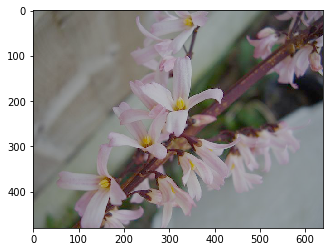

In [81]:
plt.imshow(cv2.convertScaleAbs(rgb*2.5))